In [1]:
tf_version = !pip3 show tensorflow | grep Version
if '2.2' not in tf_version[0]:
  print("downgrading tensorflow")
  !pip3 uninstall --yes tensorflow
  !pip3 install tensorflow==2.2
tf_version = !pip3 show tensorflow | grep Version
print("current tensorflow " + tf_version[0])

keras_version = !pip3 show keras | grep Version
if '2.3.1' not in keras_version[0]:
  print("downgrading keras")
  !pip3 uninstall --yes keras
  !pip3 install keras==2.3.1
keras_version = !pip3 show keras | grep Version

print("current keras " + keras_version[0])

downgrading tensorflow
Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 516.2MB 35kB/s 
     |████████████████████████████████| 3.0MB 64kB/s 
     |████████████████████████████████| 460kB 46.5MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
current tensorflow Version: 2.2.0
downgrading keras
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 8.3MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
current keras Version: 2.3.1


In [2]:
import pickle

from keras.optimizers import Adam, RMSprop
from keras import Input, layers
from keras.models import Model, load_model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
                         
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

basedir ='/content/drive/MyDrive/MB/'

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# Loading Image Features
train_features = pickle.load(open(basedir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

test_features = pickle.load(open(basedir + "encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

# Loading wordtoix
wordtoix = pickle.load(open(basedir + "PL_wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

# Loading embedding_matrix
embedding_matrix = pickle.load(open(basedir + "PL_Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

# Loading all translated descriptions
all_descriptions = pickle.load(open("/content/drive/MyDrive/MB/PL_clean_translated_descriptions.pkl", "rb"))
print('Translated descriptions: all=%d' % len(all_descriptions))

all_raw_descriptions = pickle.load(open("/content/drive/MyDrive/Translations/translated_descriptions.pkl", "rb"))
print('Raw translated descriptions: all=%d' % len(all_raw_descriptions))

Photos: train=6000
Photos: test=1000
Wordtoix Length = 20140
Embedding Matrix shape = (20140, 300)
Translated descriptions: all=8092
Raw translated descriptions: all=8092


In [5]:
all_descriptions_tagged = {k: ['startseq ' + d.lower() + ' endseq' for d in v] for k, v in all_descriptions.items()}
ixtoword = {v: k for k, v in wordtoix.items()}

train_keys = [k.split('.')[0] for k in train_features.keys()]
test_keys = [k.split('.')[0] for k in test_features.keys()]

train_descriptions = {k: all_descriptions_tagged[k] for k in train_keys}
test_descriptions = {k: all_descriptions_tagged[k] for k in test_keys}

In [6]:
max_length = 35 
vocab_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

In [7]:
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

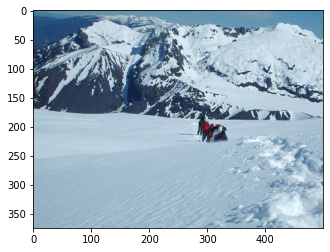

Model na danych oczyszczonych:
Greedy: osoba góry
Refs: 
 grupa wspinacz górski
grupa człowiek iść kolejka śnieg góra
linie człowiek udawać ośnieżone góra
lud iść ośnieżone poła góra tło
lud widok góra śnieg



Model na danych nieoczyszczonych:
Greedy: osoba jeździ na nartach
Refs: 
 Grupa wspinaczy górskich
Grupa ludzi idących w kolejce przez śnieg w kierunku góry
Linia ludzi udaje się przez ośnieżone góry
Ludzie idą przez ośnieżone pole z górą w tle
Ludzie z widokiem na góry w śniegu


In [8]:
directory_path = '/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'

z = 30

pic = list(train_features.keys())[z]
# pic = list(encoding_test.keys())[z]
image = train_features[pic].reshape((1,2048))
x=plt.imread(directory_path+pic)
plt.imshow(x)
plt.show()

model = load_model(basedir + 'model_pl.h5')
print("Model na danych oczyszczonych:")
result = greedySearch(image, model)
print("Greedy:", result)
print("Refs: \n", '\n'.join(all_descriptions[pic.split('.')[0]]))

print("\n\n")
model_raw = load_model(basedir + 'model_pl_raw.h5')
print("Model na danych nieoczyszczonych:")
result_raw = greedySearch(image, model_raw)
print("Greedy:", result_raw)
print("Refs: \n", '\n'.join(all_raw_descriptions[pic.split('.')[0]]))

In [14]:
import nltk
nltk.download('all')
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [52]:
from nltk.corpus import stopwords

In [53]:
en_stops = set(stopwords.words('english'))
porter = PorterStemmer()
lancaster=LancasterStemmer()
lemma=WordNetLemmatizer()
#BOW dla pojedynczego obrazka treningowego, jest to worek słów
def bow_words(image,encoding, sentence):
  pic = list(encoding.keys())[image]
  actual=all_descriptions[pic.split('.')[0]]
  word_counts = []
  if sentence == 'sentences': #dla zdań z worka uczącego
    for sent in actual:
      for w in sent.split(' '):
        w=lemma.lemmatize(w)
        w=porter.stem(w)
        if w not in word_counts:
          if w not in en_stops:
            word_counts.append(w)
  elif sentence == 'sentence': #dla przewidzianego zdania
    image = encoding[pic].reshape((1,2048))
    predicted = greedySearch(image, model)
    for w in predicted.split(' '):
      w=lemma.lemmatize(w)
      w=porter.stem(w)
      if w not in word_counts:
        if w not in en_stops:
          word_counts.append(w)
  return word_counts

In [54]:
train=[]
for i in range(len(train_features)):
  bow1=bow_words(i, train_features, 'sentences')
  train.append(bow1)

In [55]:
from operator import itemgetter 

In [56]:
def percentage_bow(images, encoding): #wartość dla konkretnego obrazka, wartości predykcji
  pic = list(encoding.keys())[images]
  actual=all_descriptions[pic.split('.')[0]]
  pred=bow_words(images,encoding, sentence='sentence')
  word_counts = []
  for sent in actual:
    for w in sent.split(' '):
      w=lemma.lemmatize(w)
      w=porter.stem(w)
      if w not in en_stops:
        if w not in word_counts:
          word_counts.append(w)
  licznik=0
  for x in pred:
    if x in word_counts:
      licznik+=1
  return licznik/len(pred)

In [57]:
def best_image_bow(image, encoding):
  pred=bow_words(image, encoding, 'sentence')
  output_train=[]
  indeks = []
  for i in range(len(encoding)):
    licznik=0
    for x in pred:
      if encoding == train_features:
        if x in train[i]:
          licznik+=1
      elif encoding == test_features:
        if x in test[i]:
          licznik+=1
    out=licznik/len(pred)
    output_train.append(out)
    indeks.append((i,out))
  wartosc=np.max(output_train)
  max_idx = max(indeks, key=itemgetter(1))[0]
  return output_train, wartosc, max_idx #wartosci predykcji i maks wartosc i numer indeksu max wartości

In [58]:
from nltk.probability import FreqDist

In [60]:
#dla zbioru treningowego
def bow_max_index_probability(encoding):
  bow_train_all = 0
  good = [] #worki ze zbiorów uczacych, dla obrazów przewidzianych poprawnie
  wrong_worki_uczace = [] #worki ze zbiorów uczacych, dla obrazów przewidzianych źle
  wrong_worki_najlepsze = [] ##worki ze zbiorów obrazków najlepszych, dla obrazów przewidzianych źle
  pred_good = [] #worki dla zdań przewidzianych poprawnie
  pred_wrong = [] #worki dla zdań przewidzianych źle
  values=[]
  val=0
  for i in range(len(encoding)):
    val_i=percentage_bow(i, encoding)
    output_train, image_val, indeks=best_image_bow(i, encoding)
    _, value_max,_=best_image_bow(indeks, encoding)
    pred=bow_words(i, encoding, 'sentence')
    if round(value_max,2) == round(image_val,2):
      bow_train_all = bow_train_all+1
      if encoding == train_features:
        for x in train[i]:
          good.append(x)
        for x in pred:
          pred_good.append(x)
      elif encoding == test_features:
        for x in test[i]:
          good.append(x)
        for x in pred:
          pred_good.append(x)
    else:
      if encoding == train_features:
        for x in train[indeks]:
          wrong_worki_najlepsze.append(x)
        for x in train[i]:
          wrong_worki_uczace.append(x)
        for x in pred:
          pred_wrong.append(x)
      elif encoding == test_features:
        for x in test[indeks]:
          wrong_worki_najlepsze.append(x)
        for x in test[i]:
          wrong_worki_uczace.append(x)
        for x in pred:
          pred_wrong.append(x)

      #posortowana lista wartości predykcji
      for j in output_train:
        if j not in values:
          values.append(j)
      for x, y in enumerate(sorted(values, reverse=True)): 
        if y == val_i:
          if y>= 0.5 and x <= (0.3*len(values)): #dodanie jako poprawnych, jesli indeks jest w 30% najlepszych wyników wartości i wartosc wieksza= 0.5
            val+=1
  answer_train = (bow_train_all+val)/(len(encoding))
  return good, pred_good, wrong_worki_najlepsze, wrong_worki_uczace, pred_wrong, answer_train

In [61]:
good, pred_good, wrong_worki_najlepsze, wrong_worki_uczace, pred_wrong, answer_train = bow_max_index_probability(train_features)

In [62]:
print('Dopasowanie najlepszego zbioru do zbioru trenującego', answer_train)

Dopasowanie najlepszego zbioru do zbioru trenującego 0.6671666666666667


<FreqDist with 678 samples and 13443 outcomes>


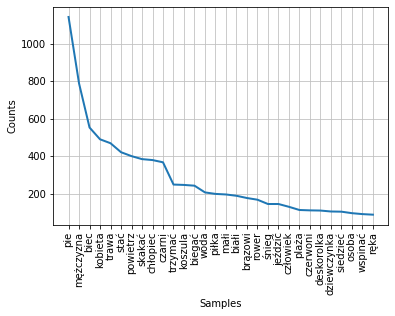

[('pie', 1144),
 ('mężczyzna', 789),
 ('biec', 553),
 ('kobieta', 490),
 ('trawa', 469),
 ('stać', 421),
 ('powietrz', 400),
 ('skakać', 384),
 ('chłopiec', 379),
 ('czarni', 367)]

In [63]:
#zdania przewidziane poprawnie
fdist = FreqDist(pred_good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 5571 samples and 62899 outcomes>


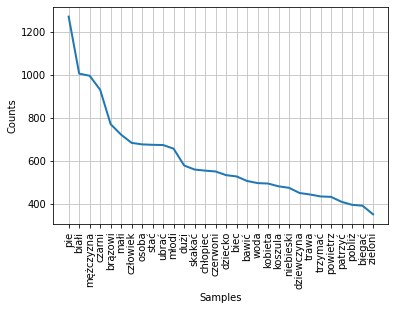

[('pie', 1270),
 ('białi', 1005),
 ('mężczyzna', 995),
 ('czarni', 930),
 ('brązowi', 770),
 ('małi', 721),
 ('człowiek', 683),
 ('osoba', 676),
 ('stać', 674),
 ('ubrać', 673)]

In [64]:
#worki dla zdań przewidzianych poprawnie
fdist = FreqDist(good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 940 samples and 10766 outcomes>


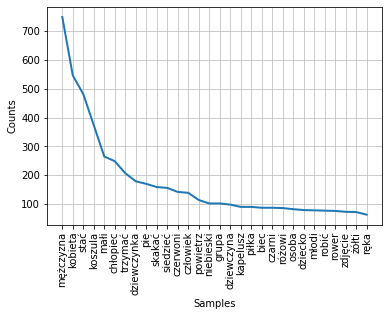

[('mężczyzna', 750),
 ('kobieta', 547),
 ('stać', 482),
 ('koszula', 374),
 ('małi', 265),
 ('chłopiec', 249),
 ('trzymać', 207),
 ('dziewczynka', 179),
 ('pie', 170),
 ('skakać', 159)]

In [65]:
#zdania przewidziane źle
fdist = FreqDist(pred_wrong)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 2984 samples and 48633 outcomes>


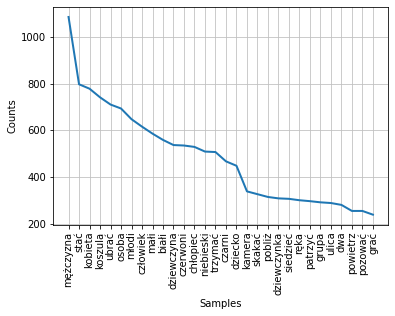

[('mężczyzna', 1087),
 ('stać', 798),
 ('kobieta', 779),
 ('koszula', 742),
 ('ubrać', 711),
 ('osoba', 694),
 ('młodi', 648),
 ('człowiek', 616),
 ('małi', 586),
 ('białi', 559)]

In [66]:
#worki dla zdań przewidzianych źle, najlepsze
fdist = FreqDist(wrong_worki_najlepsze)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 5190 samples and 45300 outcomes>


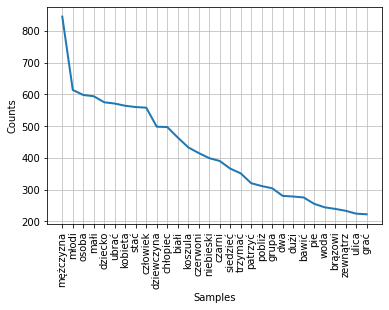

[('mężczyzna', 845),
 ('młodi', 614),
 ('osoba', 598),
 ('małi', 594),
 ('dziecko', 575),
 ('ubrać', 571),
 ('kobieta', 564),
 ('stać', 560),
 ('człowiek', 558),
 ('dziewczyna', 498)]

In [67]:
#worki dla zdań przewidzianych źle, uczące
fdist = FreqDist(wrong_worki_uczace)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

In [68]:
all_train=[]
for idx in range(len(train_features)):
  all_train.append(percentage_bow(idx, train_features))
q=np.mean(all_train)
print('Średnia wartość BOW dla zbioru treningowego',q)

Średnia wartość BOW dla zbioru treningowego 0.47458194444444446


In [69]:
#BOW dla zbioru testowego
test=[]
for i in range(len(test_features)):
  bow1=bow_words(i, test_features, 'sentences')
  test.append(bow1)

In [70]:
good_test, pred_good_test, wrong_worki_najlepsze_test, wrong_worki_uczace_test, pred_wrong_test, answer_test = bow_max_index_probability(test_features)

In [71]:
print('Dopasowanie najlepszego zbioru do zbioru testowego', answer_test)

Dopasowanie najlepszego zbioru do zbioru testowego 0.464


<FreqDist with 231 samples and 1245 outcomes>


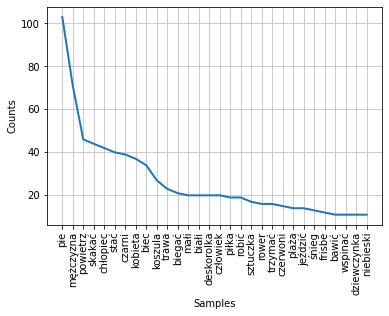

[('pie', 103),
 ('mężczyzna', 71),
 ('powietrz', 46),
 ('skakać', 44),
 ('chłopiec', 42),
 ('stać', 40),
 ('czarni', 39),
 ('kobieta', 37),
 ('biec', 34),
 ('koszula', 27)]

In [72]:
#zdania przewidziane poprawnie
fdist = FreqDist(pred_good_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1541 samples and 5612 outcomes>


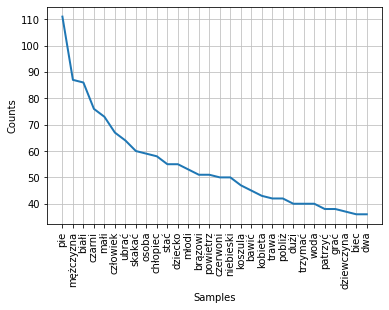

[('pie', 111),
 ('mężczyzna', 87),
 ('białi', 86),
 ('czarni', 76),
 ('małi', 73),
 ('człowiek', 67),
 ('ubrać', 64),
 ('skakać', 60),
 ('osoba', 59),
 ('chłopiec', 58)]

In [73]:
#worki dla zdań przewidzianych poprawnie
fdist = FreqDist(good_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 487 samples and 2804 outcomes>


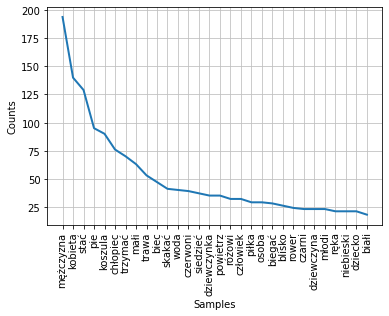

[('mężczyzna', 194),
 ('kobieta', 140),
 ('stać', 129),
 ('pie', 95),
 ('koszula', 90),
 ('chłopiec', 76),
 ('trzymać', 70),
 ('małi', 63),
 ('trawa', 53),
 ('biec', 47)]

In [74]:
#zdania przewidziane źle
fdist = FreqDist(pred_wrong_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1368 samples and 13041 outcomes>


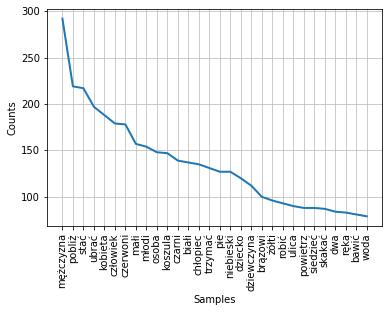

[('mężczyzna', 292),
 ('pobliż', 219),
 ('stać', 217),
 ('ubrać', 197),
 ('kobieta', 188),
 ('człowiek', 179),
 ('czerwoni', 178),
 ('małi', 157),
 ('młodi', 154),
 ('osoba', 148)]

In [75]:
#worki dla zdań przewidzianych źle, najlepsze
fdist = FreqDist(wrong_worki_najlepsze_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 2563 samples and 12426 outcomes>


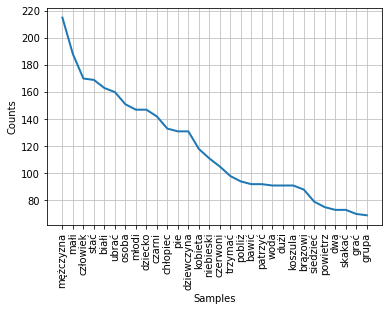

[('mężczyzna', 215),
 ('małi', 188),
 ('człowiek', 170),
 ('stać', 169),
 ('białi', 163),
 ('ubrać', 160),
 ('osoba', 151),
 ('młodi', 147),
 ('dziecko', 147),
 ('czarni', 142)]

In [76]:
#worki dla zdań przewidzianych źle, uczące
fdist = FreqDist(wrong_worki_uczace_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

In [77]:
all_test=[]
for idx in range(len(test_features)):
  all_test.append(percentage_bow(idx, test_features))
q=np.mean(all_test)
print('Średnia wartość BOW dla zbioru testowego', q)

Średnia wartość BOW dla zbioru testowego 0.3973928571428571


In [78]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_bleu(photos, descriptions):
	actual, predicted = list(), list()
	# step over the whole set
	for key, features in photos.items():
		# generate description
		yhat = greedySearch(features.reshape((1,2048)), model)
		# store actual and predicted
		descriptions_key = key.split('.')[0]
		references = [d.split() for d in all_descriptions.get(descriptions_key)]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [79]:
evaluate_bleu(train_features,all_descriptions)

BLEU-1: 0.409278
BLEU-2: 0.245887
BLEU-3: 0.180895
BLEU-4: 0.089259


In [80]:
evaluate_bleu(test_features,all_descriptions)

BLEU-1: 0.335862
BLEU-2: 0.179437
BLEU-3: 0.121406
BLEU-4: 0.053081
